In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from owslib.wms import WebMapService

from datetime import datetime
import urllib.parse
import pandas as pd

import geoengine as ge

#%matplotlib inline

<Figure size 576x576 with 0 Axes>

In [2]:
ge.initialize("http://localhost:3030")

In [3]:
session = ge.get_session()
session

Server:              http://localhost:3030
Session Id:          1fb3a985-6f5d-45b3-8417-32083181e1da

In [4]:
workflow = ge.register_workflow({
                "type": "Raster",
                "operator": {
                    "type": "GdalSource",
                    "params": {
                        "dataset": {"internal": "36574dc3-560a-4b09-9d22-d5945f2b8093"}
                    }
                }
            })
workflow

5b9508a8-bd34-5a1c-acd6-75bb832d2d38

In [5]:
fake_capabilities = '''
<WMS_Capabilities xmlns="http://www.opengis.net/wms" xmlns:sld="http://www.opengis.net/sld" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" version="1.3.0" xsi:schemaLocation="http://www.opengis.net/wms http://schemas.opengis.net/wms/1.3.0/capabilities_1_3_0.xsd http://www.opengis.net/sld http://schemas.opengis.net/sld/1.1.0/sld_capabilities.xsd">
    <Service>
        <Name>WMS</Name>
        <Title>Geo Engine WMS</Title>
    </Service>
    <Capability>
        <Request>
            <GetCapabilities>
                <Format>text/xml</Format>
                <DCPType>
                    <HTTP>
                        <Get>
                            <OnlineResource xlink:href="{wms_url}"/>
                        </Get>
                    </HTTP>
                </DCPType>
            </GetCapabilities>
            <GetMap>
                <Format>image/png</Format>
                <DCPType>
                    <HTTP>
                        <Get>
                            <OnlineResource xlink:href="{wms_url}"/>
                        </Get>
                    </HTTP>
                </DCPType>
            </GetMap>
        </Request>
        <Exception>
            <Format>XML</Format>
            <Format>INIMAGE</Format>
            <Format>BLANK</Format>
        </Exception>
        <Layer queryable="1">
            <Name>{layer_name}</Name>
            <Title>{layer_name}</Title>
            <CRS>EPSG:4326</CRS>
            <BoundingBox CRS="EPSG:4326" minx="-90.0" miny="-180.0" maxx="90.0" maxy="180.0"/>
        </Layer>
    </Capability>
</WMS_Capabilities>
'''.format(wms_url = 'http://localhost:3030/wms', layer_name = '5b9508a8-bd34-5a1c-acd6-75bb832d2d38')

In [6]:
print(fake_capabilities)


<WMS_Capabilities xmlns="http://www.opengis.net/wms" xmlns:sld="http://www.opengis.net/sld" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" version="1.3.0" xsi:schemaLocation="http://www.opengis.net/wms http://schemas.opengis.net/wms/1.3.0/capabilities_1_3_0.xsd http://www.opengis.net/sld http://schemas.opengis.net/sld/1.1.0/sld_capabilities.xsd">
    <Service>
        <Name>WMS</Name>
        <Title>Geo Engine WMS</Title>
    </Service>
    <Capability>
        <Request>
            <GetCapabilities>
                <Format>text/xml</Format>
                <DCPType>
                    <HTTP>
                        <Get>
                            <OnlineResource xlink:href="http://localhost:3030/wms"/>
                        </Get>
                    </HTTP>
                </DCPType>
            </GetCapabilities>
            <GetMap>
                <Format>image/png</Format>
                <DCPType>
                    <HTTP>

Layer Name: 5b9508a8-bd34-5a1c-acd6-75bb832d2d38 Title: 5b9508a8-bd34-5a1c-acd6-75bb832d2d38


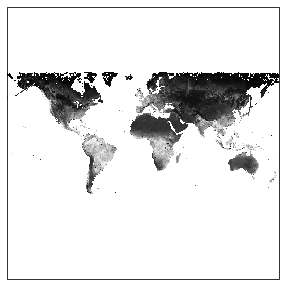

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=crs_epsg)

wms = WebMapService('http://peter.geoengine.io:6060/wms',
                    version='1.3.0',
                    xml=fake_capabilities)

print(wms['5b9508a8-bd34-5a1c-acd6-75bb832d2d38'])

#ax.coastlines()

ax.add_wms(wms,
            layers=['5b9508a8-bd34-5a1c-acd6-75bb832d2d38'],
            wms_kwargs={'time': urllib.parse.quote('2014-01-01T00:00:00.0+00:00')})

plt.show()

In [8]:
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

In [9]:
ports = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "dataset": {"internal": "a9623a5b-b6c5-404b-bc5a-313ff72e4e75"},
            "attributeProjection": None
        }
    }
})

df = ports.get_dataframe(
    ge.Bbox(
        [-180.0, -90.0, 180.0, 90.0],
        [time, time]
        )
)

df.head()

,name,website,featurecla,scalerank,natlscale,geometry,start,end
0,Sint Nicolaas,www.rocargo.com/SanNicolas.html,Port,8,5.0,POINT (-69.92356 12.43750),NaT,NaT
1,Campana,www.consejoportuario.com.ar,Port,8,5.0,POINT (-58.95141 -34.15333),NaT,NaT
2,Zarate,www.consejoportuario.com.ar,Port,8,5.0,POINT (-59.00495 -34.09889),NaT,NaT
3,Puerto Belgrano/Bahia Blanca,None,Port,8,5.0,POINT (-62.10088 -38.89444),NaT,NaT
4,Puerto Galvan/Bahia Blanca,None,Port,8,5.0,POINT (-62.30053 -38.78306),NaT,NaT


In [23]:
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

fig, ax = workflow.plot_image(
    ge.Bbox(
        [-180.0, -90.0, 180.0, 90.0],
        [time, time]
        )
)

#ax.add_geometries(df.to_crs(epsg='3857').geometry, crs=crs_epsg)

print(fig, ax)

#ax.add_geometries(df.geometry, crs=ccrs.PlateCarree(), facecolor='pink', edgecolor='pink', color='pink')

#df.plot(markersize=2, marker='o', color='red', ax=ax)

fig

Figure(576x576) < GeoAxes: <cartopy.crs.PlateCarree object at 0x7f7bd5d8e0e0> >


AttributeError: 'PathCollection' object has no property 'markersize'

In [22]:
#df['geometry'].to_crs(epsg='3857')
#ccrs.Geodetic().proj4_init
plt.show()

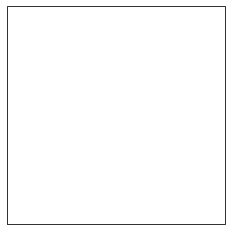

In [61]:
crs = ccrs.epsg('3857')

df_3857 = df.set_crs('EPSG:4326').to_crs('EPSG:3857')

fig, ax = plt.subplots(subplot_kw={'projection': crs_epsg})
#ax.add_geometries(df_3857.geometry, crs=crs_epsg)

ax.add_geometries(df_3857['geometry'], crs=crs_epsg,
                      facecolor='black', edgecolor='black')

In [59]:
df_3857

,website,featurecla,name,natlscale,scalerank,geometry,start,end
0,www.rocargo.com/SanNicolas.html,Port,Sint Nicolaas,5.0,8,POINT (-7783854.774 1395539.658),NaT,NaT
1,www.consejoportuario.com.ar,Port,Campana,5.0,8,POINT (-6562441.325 -4049409.576),NaT,NaT
2,www.consejoportuario.com.ar,Port,Zarate,5.0,8,POINT (-6568400.654 -4042088.130),NaT,NaT
3,None,Port,Puerto Belgrano/Bahia Blanca,5.0,8,POINT (-6913038.717 -4706562.903),NaT,NaT
4,None,Port,Puerto Galvan/Bahia Blanca,5.0,8,POINT (-6935263.280 -4690643.613),NaT,NaT
...,...,...,...,...,...,...,...,...
1076,www.vaports.com,Port,Norfolk,75.0,3,POINT (-8492844.546 4425447.906),NaT,NaT
1077,www.portseattle.org,Port,Seattle,75.0,3,POINT (-13621021.423 6040932.079),NaT,NaT
1078,www.transnetnationalportsauthority.net,Port,Cape Town,75.0,3,POINT (2052205.626 -4016611.841),NaT,NaT
1079,None,Port,Toronto,75.0,3,POINT (-8836541.179 5405285.816),NaT,NaT
